In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from gerrychain import Graph, Partition, Election, MarkovChain, proposals, updaters, constraints, accept, GeographicPartition
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from functools import partial
from gerrychain.metrics import polsby_popper
import os

In [2]:
PROCESSED_SHAPEFILE_PATH = os.path.join(os.getcwd(), "..", "shapefiles", "processed")
NC_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "north carolina", "precinct_level_w_election.shp")
ITERATIONS = 100
SAFE_SEAT_THRESHOLD = 0.66
MINORITY_POP_THRESHOLD = RACE_WINNER_THRESHOLD = 0.5
TOTAL_DISTRICTS = 13

In [3]:
nc_graph = Graph.from_file(NC_PATH, ignore_errors=True)

/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [4]:
nc_election = Election("CongressionalRace" , {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

<AxesSubplot: >

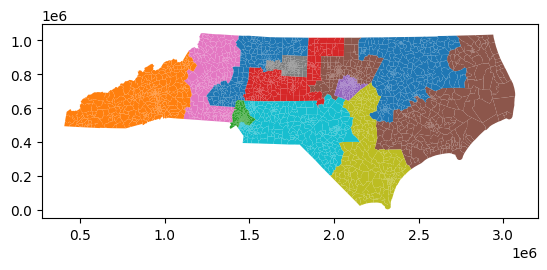

In [5]:
initial_partition = GeographicPartition(
    nc_graph,
    assignment="CD",
    updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    }
)
initial_partition.plot()

In [6]:
ideal_pop = sum(initial_partition["population"].values()) / len(initial_partition)
proposal = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop, epsilon=.02, node_repeats=2)
compactness = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [7]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        compactness,
        pop_constraint
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=ITERATIONS
)

# Polsby Popper Scores

In [8]:
polsby_popper_scores = pd.DataFrame(polsby_popper(partition) for partition in chain)
polsby_popper_scores.mean()

13    0.170565
5     0.242213
9     0.224101
11    0.174618
3     0.232804
1     0.231991
7     0.222492
8     0.209358
10    0.185865
4     0.212499
6     0.257118
12    0.226544
2     0.202886
dtype: float64

# Republican Party Splits

In [9]:
rep_splits = pd.DataFrame(partition["CongressionalRace"].percents("Republican") for partition in chain)
rep_splits.mean()

0     0.369287
1     0.544275
2     0.510302
3     0.609501
4     0.529823
5     0.573169
6     0.555292
7     0.568727
8     0.502700
9     0.389754
10    0.411036
11    0.437955
12    0.505779
dtype: float64

# Republican Safe Districts

In [10]:
rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count()

0      4
1      3
2      0
3     15
4      0
5      0
6      0
7      1
8      3
9      0
10     0
11     0
12     0
dtype: int64

# Democrat Party Splits

In [11]:
dem_splits = pd.DataFrame(partition["CongressionalRace"].percents("Democratic") for partition in chain)
dem_splits.mean()

0     0.694695
1     0.522913
2     0.446613
3     0.422916
4     0.419313
5     0.593354
6     0.431559
7     0.495539
8     0.451941
9     0.553789
10    0.404945
11    0.469804
12    0.599950
dtype: float64

# Democrat Safe Districts

In [12]:
dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count()

0     53
1     14
2      0
3      0
4      0
5     41
6      0
7     22
8      0
9     26
10     0
11    11
12     0
dtype: int64

# Populations

In [13]:
# Create dataframe of black population by district for each plan

black_pop = pd.DataFrame(partition["black"] for partition in chain)
asian_pop = pd.DataFrame(partition["asian"] for partition in chain)
hispanic_pop = pd.DataFrame(partition["hisp"] for partition in chain)
white_pop = pd.DataFrame(partition["white"] for partition in chain)

# Majority-minority districts

In [14]:
total_pop = pd.DataFrame(partition["population"] for partition in chain)
minority_pop = pd.DataFrame(asian_pop + hispanic_pop + black_pop)

In [15]:
minority_pop[minority_pop > MINORITY_POP_THRESHOLD * total_pop].count()

13     0
5      0
9      0
11     0
3      8
1      3
7      0
8      0
10     0
4      0
6      0
12    12
2     10
dtype: int64

# Equal population measure

In [16]:
equal_pop = pd.DataFrame(max(partition["population"].values()) - min(partition["population"].values()) for partition in chain)

equal_pop_measure = equal_pop.mean() / sum(initial_partition["population"].values())

# Vote Share Seat Share
## Democrat

In [17]:
dem_vote_share = pd.DataFrame(partition["CongressionalRace"].percents("Democratic") for partition in chain)
dem_seat_share = dem_vote_share[dem_vote_share > RACE_WINNER_THRESHOLD].count()

In [18]:
dem_seat_share_percentage = dem_seat_share/TOTAL_DISTRICTS
dem_vote_share_percentage = dem_vote_share.mean(axis=1).mean()

# Box & Whisker for Population

In [19]:
black_pop_box_data = pd.DataFrame(black_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
asian_pop_box_data = pd.DataFrame(asian_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
hispanic_pop_box_data = pd.DataFrame(hispanic_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
white_pop_box_data = pd.DataFrame(white_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
total_pop_box_data = pd.DataFrame(total_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])

# Export Time

In [21]:
# Export everything I've done so far to a JSON	file

import json
data = {}

data["polsby_popper_scores"] = polsby_popper_scores.mean().to_dict()
data["rep_splits"] = rep_splits.mean().to_dict()
data["dem_splits"] = dem_splits.mean().to_dict()
data["black_pop"] = black_pop.mean().to_dict()
data["asian_pop"] = asian_pop.mean().to_dict()
data["hispanic_pop"] = hispanic_pop.mean().to_dict()
data["white_pop"] = white_pop.mean().to_dict()
data["total_pop"] = total_pop.mean().to_dict()
data["minority_pop"] = minority_pop.mean().to_dict()
data["equal_pop"] = equal_pop.mean().to_dict()
data["dem_vote_share"] = dem_vote_share.mean().to_dict()
data["dem_seat_share"] = dem_seat_share.mean()
data["black_pop_box_data"] = black_pop_box_data.to_dict()
data["asian_pop_box_data"] = asian_pop_box_data.to_dict()
data["hispanic_pop_box_data"] = hispanic_pop_box_data.to_dict()
data["white_pop_box_data"] = white_pop_box_data.to_dict()
data["total_pop_box_data"] = total_pop_box_data.to_dict()

with open('data.json', 'w') as outfile:
    json.dump(data, outfile)